In [1]:
from pytorch_pretrained_bert import GPT2Tokenizer

enc = GPT2Tokenizer.from_pretrained('gpt2')

100%|██████████| 456318/456318 [00:00<00:00, 619882.57B/s]


In [2]:
CORPUS_FILE = '/Users/ben/data/wikitext-2/wiki.train.tokens'
with open(CORPUS_FILE) as f:
    corpus = f.read()
    
print(len(corpus), corpus[:100])

10780437  
 = Valkyria Chronicles III = 
 
 Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 ,


In [48]:
%%timeit -r1 -n1
sample = corpus
out = enc.encode(sample)
print(f'Compression ratio {len(out)/len(sample):.4f}')

Token indices sequence length is longer than the specified maximum  sequence length for this OpenAI GPT model (2448382 > 1024). Running this sequence through the model will result in indexing errors


Compression ratio 0.2271
8.18 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [103]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]


top [(5, 7305), (4, 7221), (6, 6456), (7, 5912), (3, 5212), (8, 5055), (9, 3845), (10, 2813), (11, 1924), (2, 1916)]
max 128


<IPython.core.display.Javascript object>


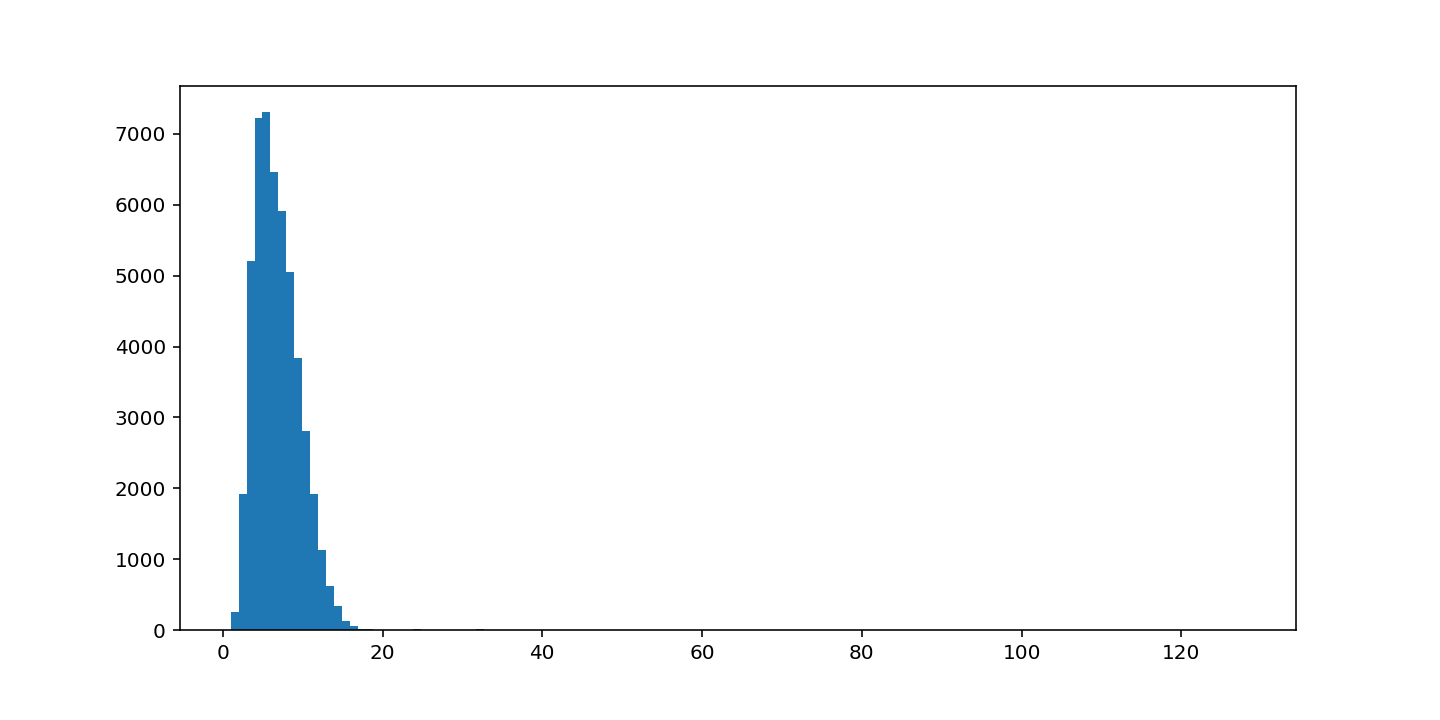

In [39]:
import numpy as np
from collections import Counter
lens = np.array([len(x) for x in enc.encoder])
print('top', Counter(lens).most_common(10))
print('max', max(lens))
plt.hist(lens, bins=max(lens))
plt.show()

In [ ]:
# Save original vocab
original_bpe_ranks = enc.bpe_ranks

In [69]:
token = list(enc.encoder.keys())[3000]
#enc.byte_decoder
#[c for c in token]
bytes([enc.byte_decoder[c] for c in token])

b' News'

In [110]:
# Greedy encoder using existing vocab

# Reprocess vocab as real bytes
vocab = [bytes(enc.byte_decoder[c] for c in token) for token in enc.encoder]
encoder = dict(zip(vocab, range(len(vocab))))
print(vocab[3000], encoder[vocab[3000]])

from bpe import Encoder

greedy = Encoder(vocab)

b' News' 3000
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
10


In [79]:
%%timeit -n1 -r1
# TODO: check this against non generator version
out = list(greedy.encode(corpus))
print(f'Compression ratio {len(out)/len(corpus):.4f}')

Compression ratio 0.3162
9.79 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [84]:
# Double check that it's reversible.
decoded = greedy.decode(out[:100])
assert corpus.startswith(decoded)

[11.504479885101318, 10.563202857971191, 11.365792989730835, 10.754388093948364, 10.559190034866333, 10.088083028793335]
[0.46924563447659867, 0.3664538830847024, 0.3456448008554755, 0.3321297643128938, 0.32381683599653704, 0.3162190920460831]


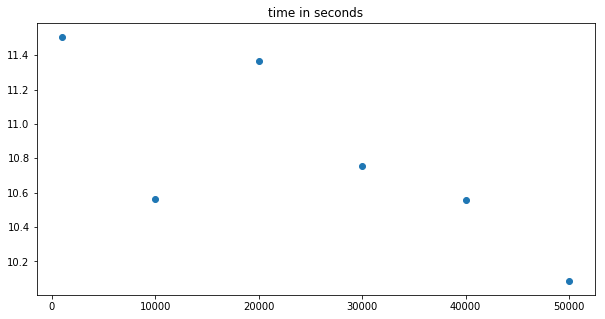

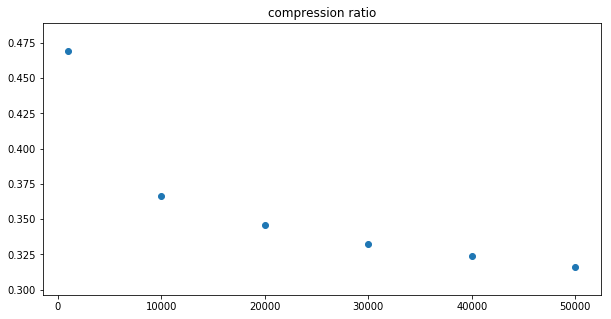

In [107]:
# Greedy encoder using only top N ranks (smaller bpe vocab)
import time, tqdm
x = (1000, 10000, 20000, 30000, 40000, 50000)
compression = []
times = []

for i in tqdm.tqdm_notebook(x):
    greedy = Encoder(vocab[:i])
    #print(greedy.max_length)
    t = time.time()
    out = list(greedy.encode(corpus))
    times.append(time.time() - t)
    compression.append(len(out)/len(corpus))

print(times)
print(compression)
    
plt.scatter(x, times)
plt.title("time in seconds")
plt.figure()
plt.title("compression ratio")
plt.scatter(x, compression)

In [113]:
# TODO: fix this
# Greedy encoder using max merge depth N

x = (2,3,4,5,10,20,40,80,128)
compression = []
times = []

for i in tqdm.tqdm_notebook(x):
    greedy = Encoder(vocab, max_length=i)
    t = time.time()
    out = list(greedy.encode(corpus[:1000]))
    times.append(time.time() - t)
    compression.append(len(out)/len(corpus))

print(times)
print(compression)
    
plt.scatter(x, times)
plt.title("time in seconds")
plt.figure()
plt.title("compression ratio")
plt.scatter(x, compression)

KeyboardInterrupt: 